In [1]:
import numpy as np
import math
import os
import cv2
from matplotlib import pyplot as plt
from google.colab import drive

Mounted at /content/drive


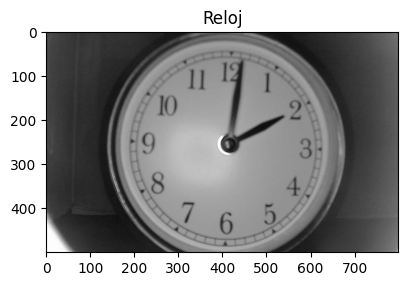

In [2]:
# cargar las imagenes
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/data-resampled')
reloj = cv2.imread("clock_0201.png")

reloj = cv2.cvtColor(reloj, cv2.COLOR_BGR2RGB)

# mostrar las imagenes
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(reloj)
plt.title('Reloj')
plt.show()

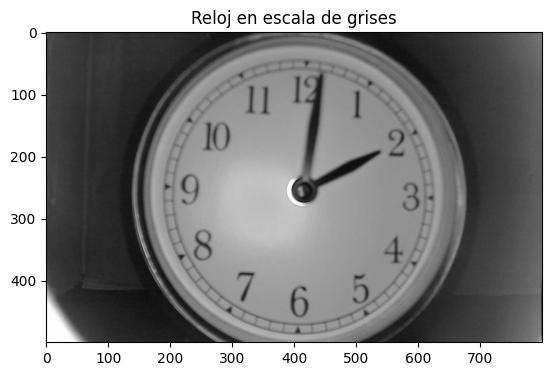

In [3]:
# escala de grises
reloj_gray = cv2.cvtColor(reloj, cv2.COLOR_RGB2GRAY)
plt.imshow(reloj_gray, cmap='gray')
plt.title('Reloj en escala de grises')
plt.show()

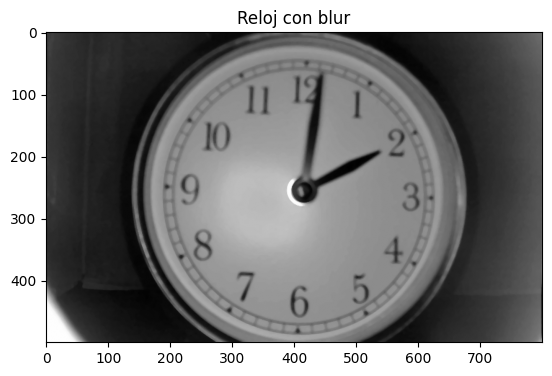

In [4]:
# aplicamos median blur
reloj_blur = cv2.medianBlur(reloj_gray, 5)
plt.imshow(reloj_blur, cmap='gray')
plt.title('Reloj con blur')
plt.show()


Círculo usado: centro=(416,260), radio=260


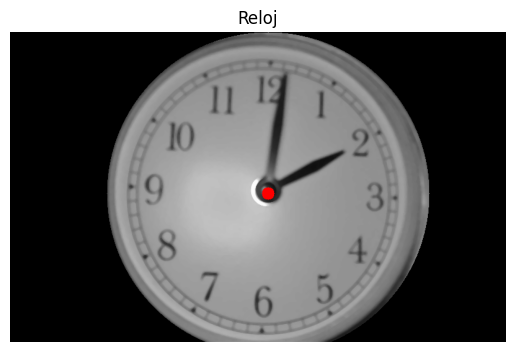

In [5]:
# Detectar círculos
circulos = cv2.HoughCircles(
    reloj_blur,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=reloj_gray.shape[0]//2,
    param1=50,
    param2=40,
    minRadius=100,
    maxRadius=300
)

if circulos is not None:
    # Convertir a enteros
    circulos = np.uint16(np.around(circulos[0]))

    # Tomar el círculo con menor radio
    x, y, r = min(circulos, key=lambda c: c[2])
    print(f"Círculo usado: centro=({x},{y}), radio={r}")

    # Crear máscara: negro fuera, blanco dentro
    mask = np.zeros_like(reloj_gray)
    cv2.circle(mask, (x, y), r, 255, -1)  # círculo blanco relleno

    # Aplicar máscara sobre la imagen original en escala de grises
    recortado = cv2.bitwise_and(reloj_blur, reloj_blur, mask=mask)

    recortado_color = cv2.cvtColor(recortado, cv2.COLOR_GRAY2BGR)
    cv2.circle(recortado_color, (x, y), 10, (0, 0, 255), -1)

    # Mostrar resultado
    plt.imshow(cv2.cvtColor(recortado_color, cv2.COLOR_BGR2RGB))
    plt.title("Reloj")
    plt.axis("off")
    plt.show()
else:
    print("No se detectaron círculos")


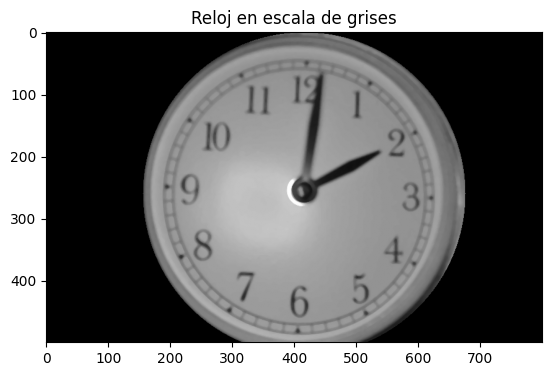

In [6]:
# mostrar la imagen recortado
plt.imshow(recortado, cmap='gray')
plt.title('Reloj en escala de grises')
plt.show()

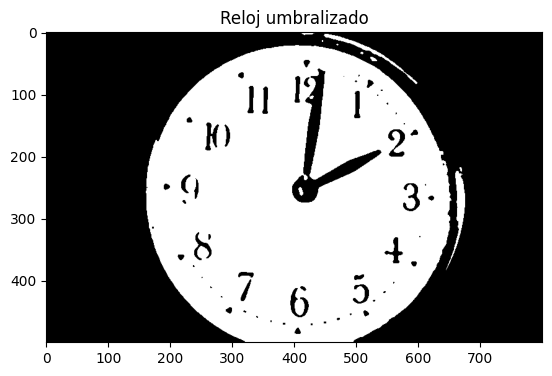

In [7]:
#Aplicamos umbral
_, thresh = cv2.threshold(recortado, 115, 255, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray')
plt.title('Reloj umbralizado')
plt.show()


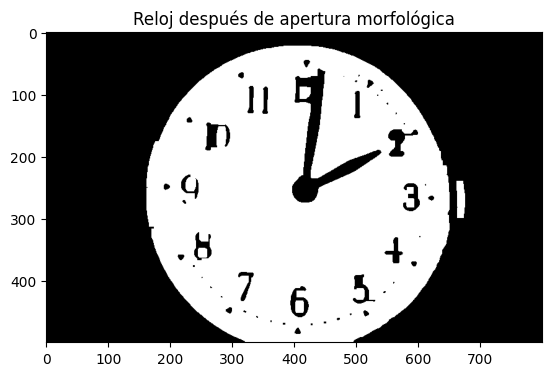

In [8]:
kernel = np.ones((3,3), np.uint8)
clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=5)
plt.imshow(clean, cmap='gray')
plt.title('Reloj después de apertura morfológica')
plt.show()


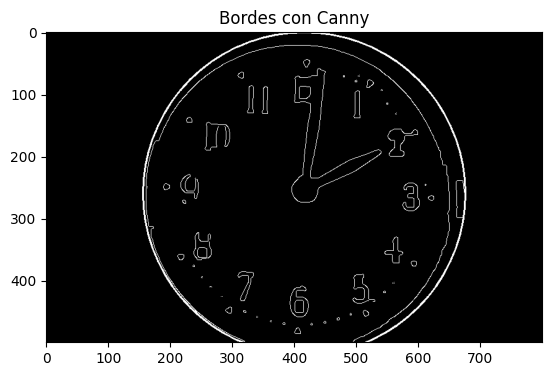

In [9]:
edges = cv2.Canny(clean, 5, 10)
cv2.circle(edges, (int(x), int(y)), int(r), (255, 255, 255), 2)

plt.imshow(edges, cmap='gray')
plt.title('Bordes con Canny')
plt.show()


Parámetros para manecilla hora: longitud mínima = 52
Parámetros para minutero: longitud mínima = 104
Líneas detectadas - minutero: 2
Líneas detectadas - hora: 90
Total líneas: 92
Líneas que parten del centro: 7
Descartando 4 líneas lejanas al centro


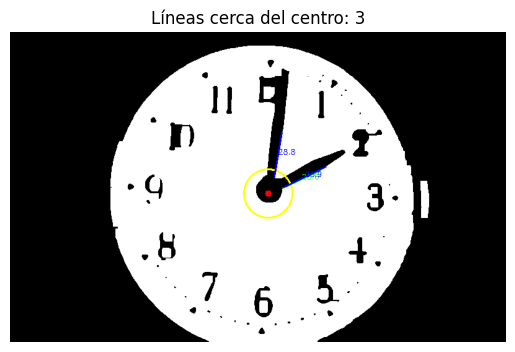

Grupos de manecillas detectados: 2
Grupo 1: 1 líneas, ángulo: 284.3°, longitud: 72.0
Grupo 2: 2 líneas, ángulo: 336.2°, longitud: 70.9


In [10]:
min_line_length_hora = int(r * 0.2)  # Más corto para manecilla de hora
min_line_length_minuto = int(r * 0.4)  # Más largo para minutero

print(f"Parámetros para manecilla hora: longitud mínima = {min_line_length_hora}")
print(f"Parámetros para minutero: longitud mínima = {min_line_length_minuto}")

# Detectar líneas con parámetros para manecillas LARGAS (minutero)
lines_minutero = cv2.HoughLinesP(
    edges,
    rho=1,
    theta=np.pi/180,
    threshold=int(r * 0.15),
    minLineLength=min_line_length_minuto,
    maxLineGap=int(r * 0.08)
)

# Detectar líneas con parámetros para manecillas CORTAS (hora)
lines_hora = cv2.HoughLinesP(
    edges,
    rho=1,
    theta=np.pi/180,
    threshold=int(r * 0.1),  # Umbral más bajo para detectar líneas cortas
    minLineLength=min_line_length_hora,
    maxLineGap=int(r * 0.12)  # Gap más grande
)

# Combinar ambas detecciones
all_lines = []
if lines_minutero is not None:
    all_lines.extend(lines_minutero)
if lines_hora is not None:
    all_lines.extend(lines_hora)

print(f"Líneas detectadas - minutero: {len(lines_minutero) if lines_minutero is not None else 0}")
print(f"Líneas detectadas - hora: {len(lines_hora) if lines_hora is not None else 0}")
print(f"Total líneas: {len(all_lines)}")

# FILT para manecillas cortas
valid_hand_lines = []

if len(all_lines) > 0:
    for line in all_lines:
        x1, y1, x2, y2 = line[0]

        # Calcular distancias de ambos extremos al centro
        dist1 = np.sqrt((x1 - x)**2 + (y1 - y)**2)
        dist2 = np.sqrt((x2 - x)**2 + (y2 - y)**2)

        # CRITERIO PRINCIPAL: AL MENOS UN EXTREMO MUY CERCA DEL CENTRO
        cerca_del_centro = min(dist1, dist2) < r * 0.15  # Más estricto (15% del radio)

        if not cerca_del_centro:
            continue  # Descartar si no está cerca del centro

        # Calcular punto medio
        mid_x = (x1 + x2) // 2
        mid_y = (y1 + y2) // 2

        # Longitud de la línea
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

        # Ángulo de la línea respecto al centro
        angle = np.degrees(np.arctan2(mid_y - y, mid_x - x))
        if angle < 0:
            angle += 360

        # FILTROS ADICIONALES
        is_inside_circle = max(dist1, dist2) < r * 0.9  # No cerca del borde
        valid_length = r * 0.2 < length < r * 0.8  # Longitud adecuada

        # Verificar que la línea sea radial (apunte hacia/desde el centro)
        line_angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        if line_angle < 0:
            line_angle += 180
        angle_diff = abs((angle - line_angle) % 180)
        es_radial = angle_diff < 20 or angle_diff > 160

        if cerca_del_centro and is_inside_circle and valid_length and es_radial:
            valid_hand_lines.append({
                'coords': (x1, y1, x2, y2),
                'angle': angle,
                'length': length,
                'midpoint': (mid_x, mid_y),
                'dist_to_center': min(dist1, dist2),
                'cerca_centro': cerca_del_centro
            })

print(f"Líneas que parten del centro: {len(valid_hand_lines)}")

# ORDENAR POR PROXIMIDAD AL CENTRO (las más cercanas primero)
valid_hand_lines.sort(key=lambda x: x['dist_to_center'])

# MOSTRAR SOLO LAS 2-3 LÍNEAS MÁS CERCANAS AL CENTRO
if len(valid_hand_lines) > 3:
    print(f"Descartando {len(valid_hand_lines) - 3} líneas lejanas al centro")
    valid_hand_lines = valid_hand_lines[:3]  # Mantener solo las 3 más cercanas

# VISUALIZACIÓN DE LÍNEAS CERCANAS AL CENTRO
center_image = cv2.cvtColor(clean, cv2.COLOR_GRAY2BGR)
cv2.circle(center_image, (x, y), int(r * 0.15), (0, 255, 255), 2)  # Círculo de 15% del radio
cv2.circle(center_image, (x, y), 5, (0, 0, 255), -1)  # Centro

for i, hand in enumerate(valid_hand_lines):
    x1, y1, x2, y2 = hand['coords']
    color = (0, 255, 0) if i == 0 else (255, 0, 0)
    cv2.line(center_image, (x1, y1), (x2, y2), color, 2)
    cv2.putText(center_image, f"{hand['dist_to_center']:.1f}", hand['midpoint'],
               cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

plt.imshow(cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB))
plt.title(f'Líneas cerca del centro: {len(valid_hand_lines)}')
plt.axis("off")
plt.show()

# AGRUPAR LÍNEAS POR ÁNGULO SIMILAR
def group_hands(hand_list, angle_threshold=15):
    """Agrupa líneas con ángulos similares (misma manecilla)"""
    if not hand_list:
        return []

    groups = []
    for hand in sorted(hand_list, key=lambda x: x['angle']):
        found_group = False
        for group in groups:
            group_angle = np.mean([h['angle'] for h in group])
            angle_diff = abs(hand['angle'] - group_angle)
            angle_diff = min(angle_diff, 360 - angle_diff)  # Distancia circular

            if angle_diff < angle_threshold:
                group.append(hand)
                found_group = True
                break
        if not found_group:
            groups.append([hand])

    return groups

# Agrupar líneas válidas
hand_groups = group_hands(valid_hand_lines, angle_threshold=12)
print(f"Grupos de manecillas detectados: {len(hand_groups)}")

# Crear líneas representativas para cada grupo
final_hands = []
for i, group in enumerate(hand_groups):
    if len(group) > 0:
        # Calcular ángulo promedio del grupo
        angulos = [h['angle'] for h in group]
        angulo_promedio = np.mean(angulos)

        # Calcular longitud promedio
        longitudes = [h['length'] for h in group]
        longitud_promedio = np.mean(longitudes)

        # Calcular punto final de la línea representativa
        end_x = int(x + longitud_promedio * np.cos(np.radians(angulo_promedio)))
        end_y = int(y + longitud_promedio * np.sin(np.radians(angulo_promedio)))

        final_hands.append({
            'coords': (x, y, end_x, end_y),
            'angle': angulo_promedio,
            'length': longitud_promedio,
            'midpoint': ((x + end_x)//2, (y + end_y)//2),
            'group_size': len(group)
        })

        print(f"Grupo {i+1}: {len(group)} líneas, ángulo: {angulo_promedio:.1f}°, longitud: {longitud_promedio:.1f}")

In [11]:
def calcular_hora(final_hands, cx, cy):
    if len(final_hands) < 2:
        print(" No se detectaron suficientes manecillas")
        return None

    # Clasificar: corta = hora, larga = minutos
    hands_sorted = sorted(final_hands, key=lambda h: h['length'])
    hora_hand = hands_sorted[0]
    minuto_hand = hands_sorted[-1]

    def to_clock_angle(angle):
        return (angle + 90) % 360  # 0° en 12h, horario

    # Convertir ángulos
    ang_h = to_clock_angle(hora_hand['angle'])
    ang_m = to_clock_angle(minuto_hand['angle'])

    # Minutos
    minutos = int(round(ang_m / 6)) % 60

    # Horas (proporcional con minutos)
    horas = int(((ang_h / 30.0) + (minutos / 60.0)) % 12)
    if horas == 0:
        horas = 12

    return horas, minutos


In [12]:
hora, minutos = calcular_hora(final_hands, x, y)
print(f"Hora detectada: {hora:02d}:{minutos:02d}")


Hora detectada: 02:02
